In [1]:
import pandas as pd
import numpy as np
import scipy

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


import statsmodels.api as sm
from linearmodels.system import SUR

import matplotlib.pyplot as plt

import os
import datetime

### Read Data

In [2]:
# Read in the CCI data
CCI_data = pd.read_csv('../Data/CCI.csv')
CCI_data.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,NLD,CCI,AMPLITUD,LTRENDIDX,M,1991-01,99.75915,NaN
1,NLD,CCI,AMPLITUD,LTRENDIDX,M,1991-02,99.74998,NaN
2,NLD,CCI,AMPLITUD,LTRENDIDX,M,1991-03,99.88835,NaN
3,NLD,CCI,AMPLITUD,LTRENDIDX,M,1991-04,99.95676,NaN
4,NLD,CCI,AMPLITUD,LTRENDIDX,M,1991-05,100.01380,NaN


In [3]:
# Read in the ICS data
ICS_data = pd.read_csv('../Data/ICS.csv')
ICS_data.head()

,Month,YYYY,ICS_ALL
0,November,1952,86.2
1,February,1953,90.7
2,August,1953,80.8
3,November,1953,80.7
4,February,1954,82.0


In [4]:
# Read in AUS data
AUS_data = pd.read_csv('../Data/S&P_ASX_200.csv')
AUS_data.head()

,Date,Price,Open,High,Low,Volume
0,30-Jul-19,6845.1,6825.8,6875.5,6825.8,601530000
1,29-Jul-19,6825.8,6793.4,6834.4,6793.4,532540000
2,26-Jul-19,6793.4,6818.0,6818.0,6779.5,664360000
3,25-Jul-19,6818.0,6776.7,6818.0,6771.1,681660000
4,24-Jul-19,6776.7,6724.6,6783.3,6724.6,629990000


In [5]:
# Read in the SAD data
SAD_data = pd.read_csv('../Data/daily_incidence.txt', sep='\t')
SAD_data

,Julian date,Incidence
0,1,0.962275
1,2,0.961698
2,3,0.961067
3,4,0.960381
4,5,0.959638
...,...,...
361,362,0.964078
362,363,0.963701
363,364,0.963275
364,365,0.962800


### Helper Functions

In [6]:
# Get calendar month and day from Julian date
def get_month_day_AUS(julian):
    jul_AUS = (julian+182)%366 + 1
    if jul_AUS < 60:
        month = datetime.datetime.strptime(str(jul_AUS), '%j').month
        day = datetime.datetime.strptime(str(jul_AUS), '%j').day
    elif jul_AUS > 60:
        month = datetime.datetime.strptime(str(jul_AUS-1), '%j').month
        day = datetime.datetime.strptime(str(jul_AUS-1), '%j').day
    else:  # leap day
        month = 2
        day = 29
    return month, day

In [7]:
def bid_ask_estimate(df, id_col='PERMNO', date_col='DATE', high_col='ASKHI', low_col='BIDLO'):
    """
    Inputs:
     - df [DataFrame]: contains all data
     - id_col [str]: name of stock identifying column
     - date_col [str]: name of date column
     - high_col [str]: name of column for high price
     - low_col [str]: name of column for low price
    
    Return: modifies df input to contain the Corwin-Schultz estimate of the bid-ask spread
    """
    
    i = 1
    if id_col:
        for k, group in df.groupby(id_col):
            group.sort_values(date_col)
            group["next_H"] = group[high_col].shift(-1) # Get high for next day
            group["next_L"] = group[low_col].shift(-1) # Get low for next day

            if i == 1:
                temp = group
            else:
                temp = pd.concat([temp, group])

            i += 1
    else:
        temp = df.copy()
        temp["next_H"] = temp[high_col].shift(-1) # Get high for next day
        temp["next_L"] = temp[low_col].shift(-1) # Get low for next day

        
    # beta = E{sum(j=0,1)[ln(H_(t+j)/L_(t+j))]^2} where H_t is the observed high price on day t (similarly for L)
    beta = np.mean((np.log(temp[high_col]/temp[low_col])**2 + np.log(temp.next_H/temp.next_L)**2))
#     beta = (np.log(temp[high_col]/temp[low_col])**2 + np.log(temp.next_H/temp.next_L)**2)
    
    # gamma = [ln(H_(t, t+1)/L_(t, t+1))]^2 where H_(t, t+1) is the high price over days t and t+1 (similarly for L)
    gamma = (np.log(np.maximum(temp[high_col], temp.next_H)/np.minimum(temp[low_col], temp.next_L)))**2
    
    # alpha = ((2beta)^0.5-beta^0.5)/(3-2*2^0.5) - (gamma/(3-2*2^0.5))^0.5
    alpha = (np.sqrt(2*beta)-np.sqrt(beta))/(3-2*np.sqrt(2)) - np.sqrt(gamma/(3-2*np.sqrt(2)))
        
    # high-low spread estimate S = 2(e^alpha - 1)/(1+e^alpha)
    S = 2*(np.exp(alpha)-1)/(1+np.exp(alpha))
    
    temp['CW_spread_estimate'] = S
    
    return temp

In [8]:
def split_date_field(df, date_field):
    '''
    Extracts year and month columns from date column
    
    Return: df with month and year columns
    '''
    new_df = df.copy()
    
    split_date = new_df[date_field].str.split('-', n=1, expand=True)
    
    new_df['Year'] = split_date[0].astype(int)
    new_df['Month'] = split_date[1].astype(int)
    
    return new_df
    
def get_integer_month(df, month_field, short_names=False):
    '''
    Get months as integers from string month field
    
    Return: df with updated month field to have integer values
    '''
    
    new_df = df.copy()
    
    # Check for integer months
    if pd.api.types.is_integer_dtype(df[month_field]):
        print("Month field already in integer form.")
        return df
    
    # If not integer months, convert months to integers
    if short_names:
        new_df[month_field] = new_df[month_field].apply(lambda x: datetime.datetime.strptime(x, "%b").month)
    
    else:
        new_df[month_field] = new_df[month_field].apply(lambda x: datetime.datetime.strptime(x, "%B").month)

    return new_df

In [9]:
def get_daily_data(df, trading_days, year_field, month_field, day_field=None, cols_to_keep=None):
    '''
    Interpolates the data on a daily basis from a monthly basis (same value between dates)
    
    Return: df with daily data
    '''
    
    trading_d = trading_days.day
    trading_months = trading_days.month
    trading_years = trading_days.year
    
    if day_field:
        date_df = pd.DataFrame({'Date': trading_days, 'Day': trading_d, 'Month': trading_months})
    else:
        date_df = pd.DataFrame({'Date': trading_days, 'Year': trading_years, 'Month': trading_months})
    
    if cols_to_keep:
        # Assume no day_field
        merged_df = date_df.merge(df[cols_to_keep+[year_field]+[month_field]], left_on=['Year', 'Month'], 
                                  right_on=[year_field, month_field], how='left')
    
    else:
        if day_field:
            merged_df = date_df.merge(df, left_on=['Month', 'Day'], 
                                  right_on=[month_field, day_field], how='left')
        else:
            merged_df = date_df.merge(df, left_on=['Year', 'Month'], 
                                  right_on=[year_field, month_field], how='left')
    
    return merged_df

## Preprocess Data - AUS

In [10]:
# Get trading days
trading_days = pd.to_datetime(AUS_data.Date.unique().astype(str))

# Australian confidence index
CCI_data_AUS = CCI_data[CCI_data.LOCATION == 'AUS']
CCI_data_AUS = split_date_field(CCI_data_AUS, 'TIME')
CCI_data_AUS = CCI_data_AUS.groupby(['TIME']).mean()[['Value', 'Year', 'Month']].reset_index()

# Get daily data for CCI and ICS
CCI_AUS_daily = get_daily_data(CCI_data_AUS, trading_days, 'Year', 'Month')

# Get rid of unnecessary columns, rename columns
CCI_AUS_daily = CCI_AUS_daily.drop(['Year', 'TIME', 'Month'], axis=1)
CCI_AUS_daily = CCI_AUS_daily.rename({'Value': 'CCI'}, axis='columns')
CCI_AUS_daily['CCI'] = CCI_AUS_daily['CCI'] - 100 # Center data round 1985 (100)

# Get Bid-Ask Estimate for AUS Data
AUS_df = bid_ask_estimate(AUS_data, id_col = None, date_col='Date', high_col='High', low_col='Low')

# Convert date field to datetime
AUS_df['Date'] = pd.to_datetime(AUS_df.Date.astype(str))
AUS_df = AUS_df.sort_values('Date')
AUS_df

,Date,Price,Open,High,Low,Volume,next_H,next_L,CW_spread_estimate
4110,2003-07-11,3043.8,3042.8,3044.9,3024.8,435660000,NaN,NaN,NaN
4109,2003-07-14,3074.0,3043.8,3079.0,3043.7,278580000,3044.9,3024.8,-0.001041
4108,2003-07-15,3081.9,3074.0,3087.2,3074.0,430170000,3079.0,3043.7,0.007575
4107,2003-07-16,3095.3,3081.9,3095.3,3071.2,473330000,3087.2,3074.0,0.022963
4106,2003-07-17,3088.0,3095.3,3095.3,3073.3,417670000,3095.3,3071.2,0.022963
...,...,...,...,...,...,...,...,...,...
4,2019-07-24,6776.7,6724.6,6783.3,6724.6,629990000,6730.7,6688.8,0.007965
3,2019-07-25,6818.0,6776.7,6818.0,6771.1,681660000,6783.3,6724.6,0.008534
2,2019-07-26,6793.4,6818.0,6818.0,6779.5,664360000,6818.0,6771.1,0.025169
1,2019-07-29,6825.8,6793.4,6834.4,6793.4,532540000,6818.0,6779.5,0.022362


In [11]:
ICS_data_cleaned = get_integer_month(ICS_data, 'Month')
ICS_daily = get_daily_data(ICS_data_cleaned, trading_days, 'YYYY', 'Month')
ICS_daily = ICS_daily.drop(['Year', 'YYYY', 'Month'], axis=1)
ICS_daily = ICS_daily.rename({'ICS_ALL': 'ICS'}, axis='columns')

In [12]:
# Get daily data for CCI USA
CCI_data_cleaned = CCI_data[CCI_data.LOCATION == 'USA']
CCI_data_cleaned = split_date_field(CCI_data_cleaned, 'TIME')
CCI_data_cleaned = CCI_data_cleaned.groupby(['TIME']).mean()[['Value', 'Year', 'Month']].reset_index()
CCI_daily = get_daily_data(CCI_data_cleaned, trading_days, 'Year', 'Month')

# Get rid of unnecessary columns, rename columns
CCI_daily = CCI_daily.drop(['Year', 'TIME', 'Month'], axis=1)
CCI_daily = CCI_daily.rename({'Value': 'USA'}, axis='columns')
CCI_daily['USA'] = CCI_daily['USA']-100 # Center around 1985 (100)

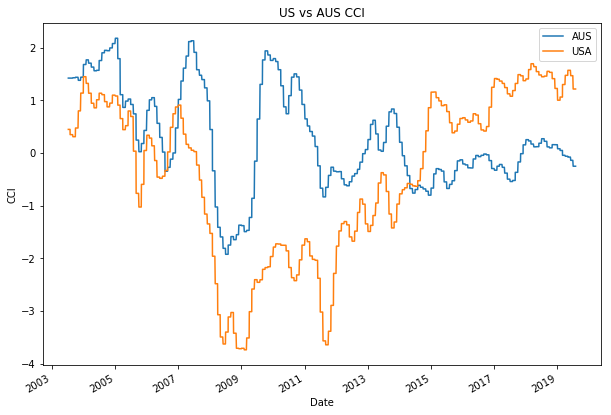

In [29]:
CCI_daily['AUS'] = CCI_AUS_daily['CCI']
CCI_daily.plot(x='Date',y=['AUS','USA'], figsize=(10,7), title='US vs AUS CCI', ylabel='CCI')

# different economic experiences over a large part of the period under investigation (emphasize in caveats)

In [14]:
# Understand data that gives rise to the CCI calculation
# Understand what it means economically
# CCI_data_AUS.Value.unique()

In [15]:
# Get month and day for SAD data, and get values for trading_days
SAD_data[['Month', 'Day']] = pd.DataFrame(list(SAD_data['Julian date'].apply(lambda x: get_month_day_AUS(x))))
SAD_daily = get_daily_data(SAD_data, trading_days, None, 'Month', 'Day')[['Date', 'Incidence']]
SAD_daily.head()

,Date,Incidence
0,2019-07-30,0.916433
1,2019-07-29,0.919617
2,2019-07-26,0.928219
3,2019-07-25,0.930793
4,2019-07-24,0.933231


##### Get Volume, Variance

In [16]:
# Volume Calculation
# Get relevant columns
AUS_subset = AUS_df[['Date','Volume','Price']].copy()

# Get the dollar volume for the previous day for each stock
AUS_subset.sort_values('Date')
AUS_subset['PRC_shifted'] = abs(AUS_subset['Price']).shift(1) # Shifted price, taking absolute values
AUS_subset['VOL_shifted'] = AUS_subset['Volume'].shift(1) # Shifted volume
AUS_subset['DLR_VOL'] = AUS_subset.PRC_shifted*AUS_subset.VOL_shifted # Previous day's dollar volume
    
# Return Calculation
AUS_subset['daily_return'] = (abs(AUS_subset.Price)-abs(AUS_subset.PRC_shifted))/abs(AUS_subset.PRC_shifted) # Return

# Get the variances based on 21-day periods for each stock
period_length = 21
AUS_subset['variance'] = AUS_subset.daily_return.rolling(period_length).var()

# Remove NaN rows
AUS_subset = AUS_subset.dropna()
AUS_subset.head()

,Date,Volume,Price,PRC_shifted,VOL_shifted,DLR_VOL,daily_return,variance
4089,2003-08-11,331210000,3145.8,3149.4,323860000.0,1.019965e+12,-0.001143,0.000022
4088,2003-08-12,424250000,3142.7,3145.8,331210000.0,1.041920e+12,-0.000985,0.000019
4087,2003-08-13,410930000,3158.1,3142.7,424250000.0,1.333290e+12,0.004900,0.000019
4086,2003-08-14,457740000,3150.4,3158.1,410930000.0,1.297758e+12,-0.002438,0.000019
4085,2003-08-15,395670000,3148.0,3150.4,457740000.0,1.442064e+12,-0.000762,0.000019


##### Detrend

In [17]:
import warnings
warnings.filterwarnings("ignore")

# Calculate average (volume, variance) over last 252 days
AUS_subset.sort_values('Date')
AUS_subset['AVG_DLR_VOL'] = AUS_subset.DLR_VOL.rolling(252).mean()
AUS_subset['AVG_VAR'] = AUS_subset.variance.rolling(252).mean()
        
# Calculate the detrended volume and variance
AUS_subset['DLR_VOL_detrended'] = AUS_subset.DLR_VOL/AUS_subset.AVG_DLR_VOL
AUS_subset['VAR_detrended'] = AUS_subset.variance/AUS_subset.AVG_VAR

# Save to AUS_df table
AUS_df['DLR_VOL_detrended'] = AUS_subset['DLR_VOL_detrended'] 
AUS_df['VAR_detrended'] = AUS_subset['VAR_detrended'] 
AUS_df['DLR_VOL'] = AUS_subset['DLR_VOL'] 
AUS_df['DLY_RETURN'] = AUS_subset['daily_return'] 
AUS_df['DLY_VARIANCE'] = AUS_subset['variance'] 

AUS_df = AUS_df.dropna()
AUS_df = AUS_df[AUS_df.CW_spread_estimate >= 0] # Remove negative spread estimates
AUS_df

,Date,Price,Open,High,Low,Volume,next_H,next_L,CW_spread_estimate,DLR_VOL_detrended,VAR_detrended,DLR_VOL,DLY_RETURN,DLY_VARIANCE
3838,2004-08-05,3538.9,3546.8,3546.8,3524.9,456650000,3558.0,3541.2,0.019270,0.938999,1.046477,1.348473e+12,-0.002002,0.000021
3837,2004-08-06,3530.6,3534.8,3535.9,3519.3,455540000,3546.8,3524.9,0.023042,1.123466,1.050801,1.616039e+12,-0.002345,0.000021
3836,2004-08-09,3509.2,3527.8,3527.8,3495.4,371590000,3535.9,3519.3,0.014023,1.116362,1.124227,1.608330e+12,-0.006061,0.000022
3835,2004-08-10,3499.6,3507.5,3516.8,3498.9,539130000,3527.8,3495.4,0.019559,0.905185,1.131346,1.303984e+12,-0.002736,0.000022
3834,2004-08-11,3511.1,3506.0,3526.3,3506.0,466830000,3516.8,3498.9,0.023002,1.307594,1.168964,1.886739e+12,0.003286,0.000023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2019-07-24,6776.7,6724.6,6783.3,6724.6,629990000,6730.7,6688.8,0.007965,1.141826,0.551411,4.326204e+12,0.007748,0.000028
3,2019-07-25,6818.0,6776.7,6818.0,6771.1,681660000,6783.3,6724.6,0.008534,1.125664,0.563102,4.269253e+12,0.006094,0.000028
2,2019-07-26,6793.4,6818.0,6818.0,6779.5,664360000,6818.0,6771.1,0.025169,1.224685,0.577495,4.647558e+12,-0.003608,0.000029
1,2019-07-29,6825.8,6793.4,6834.4,6793.4,532540000,6818.0,6779.5,0.022362,1.189612,0.521391,4.513263e+12,0.004769,0.000026


##### Combine Relevant Columns with CCI data

In [18]:
final_AUS_data = AUS_df[['Date','CW_spread_estimate', 'DLR_VOL_detrended', 'VAR_detrended']].merge(CCI_AUS_daily, on=['Date'], how='left')
final_AUS_data = final_AUS_data.merge(ICS_daily, on=['Date'], how='left')
final_AUS_data = final_AUS_data.merge(SAD_daily, on=['Date'], how='left')
final_AUS_data = final_AUS_data.set_index('Date')
final_AUS_data

,CW_spread_estimate,DLR_VOL_detrended,VAR_detrended,CCI,ICS,Incidence
Date,,,,,,
2004-08-05,0.019270,0.938999,1.046477,1.90170,95.9,0.893488
2004-08-06,0.023042,1.123466,1.050801,1.90170,95.9,0.888949
2004-08-09,0.014023,1.116362,1.124227,1.90170,95.9,0.873938
2004-08-10,0.019559,0.905185,1.131346,1.90170,95.9,0.868442
2004-08-11,0.023002,1.307594,1.168964,1.90170,95.9,0.862685
...,...,...,...,...,...,...
2019-07-24,0.007965,1.141826,0.551411,-0.25258,98.4,0.933231
2019-07-25,0.008534,1.125664,0.563102,-0.25258,98.4,0.930793
2019-07-26,0.025169,1.224685,0.577495,-0.25258,98.4,0.928219


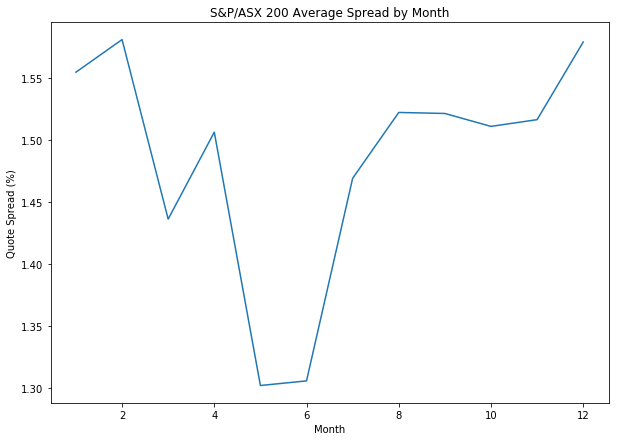

In [28]:
test_data = final_AUS_data.reset_index()
month = test_data['Date'].apply(lambda x: x.month)
test_data['Month'] = month
test_data2 = test_data.groupby('Month').mean()['CW_spread_estimate']*100
test_data2.plot(title='S&P/ASX 200 Average Spread by Month', ylabel='Quote Spread (%)', legend=False, figsize=(10,7))

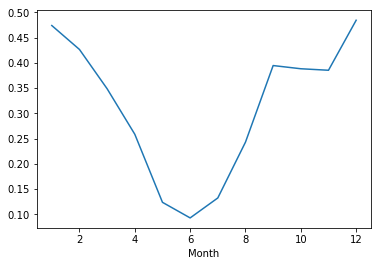

In [20]:
test_data3 = test_data.groupby('Month').mean()['CCI']
test_data3.plot()

#### Get Summary Statistics - AUS

In [21]:
pd.set_option('float_format', '{:.2f}'.format)

# Summary over all AUS data
summary_cols = ['Quote Spread (%)', 'Volume ($million)', 'Daily Return (%)', 'Return Variance (%)']

AUS_df['Quote Spread (%)'] = AUS_df.CW_spread_estimate*100
AUS_df['Volume ($million)'] = AUS_df.DLR_VOL/1000000
AUS_df['Daily Return (%)'] = AUS_df.DLY_RETURN*100
AUS_df['Return Variance (%)'] = AUS_df.DLY_VARIANCE*100

AUS_df[summary_cols].describe().transpose()[['mean', 'std', 'min', 'max']]

,mean,std,min,max
Quote Spread (%),1.48,0.79,0.00,3.41
Volume ($million),3318202.15,1252984.47,0.00,22900365.00
Daily Return (%),0.06,0.56,-1.63,1.65
Return Variance (%),0.01,0.00,0.00,0.05


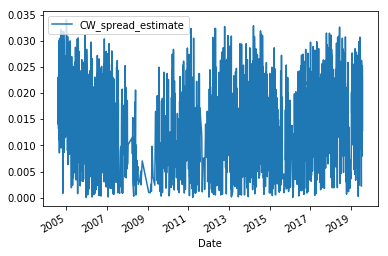

In [22]:
AUS_df.plot(x='Date', y='CW_spread_estimate')

## Run Linear Regression

In [23]:
# Potentially transform CCI data? summarize

In [24]:
# Difficult to use Corwin-Schultz as it may be changing over time period 
# -- source of potential weakness in analysis results
# a) Present results and remaining questions (weaknesses and caveats) as next steps,
# emphasize that they are not final results
# b) Present only results that make sense (less recommended)

X = sm.add_constant(final_AUS_data[['DLR_VOL_detrended', 'VAR_detrended', 'CCI', 'Incidence']])
Y = final_AUS_data['CW_spread_estimate']

model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     CW_spread_estimate   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     37.43
Date:                Sun, 11 Apr 2021   Prob (F-statistic):           1.83e-30
Time:                        14:21:47   Log-Likelihood:                 8783.1
No. Observations:                2549   AIC:                        -1.756e+04
Df Residuals:                    2544   BIC:                        -1.753e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0194      0.00

In [25]:
X = sm.add_constant(final_AUS_data[['DLR_VOL_detrended', 'VAR_detrended', 'CCI', 'Incidence']])
Y = final_AUS_data['CW_spread_estimate']

model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     CW_spread_estimate   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     37.43
Date:                Sun, 11 Apr 2021   Prob (F-statistic):           1.83e-30
Time:                        14:21:47   Log-Likelihood:                 8783.1
No. Observations:                2549   AIC:                        -1.756e+04
Df Residuals:                    2544   BIC:                        -1.753e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0194      0.00

In [26]:
X = sm.add_constant(final_AUS_data[['DLR_VOL_detrended', 'VAR_detrended', 'CCI']])
Y = final_AUS_data['CW_spread_estimate']

model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     CW_spread_estimate   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     48.89
Date:                Sun, 11 Apr 2021   Prob (F-statistic):           1.02e-30
Time:                        14:21:47   Log-Likelihood:                 8781.7
No. Observations:                2549   AIC:                        -1.756e+04
Df Residuals:                    2545   BIC:                        -1.753e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0193      0.00

In [27]:
# Correlation
final_AUS_data.corr()

,CW_spread_estimate,DLR_VOL_detrended,VAR_detrended,CCI,ICS,Incidence
CW_spread_estimate,1.00,-0.07,-0.19,0.09,0.22,-0.07
DLR_VOL_detrended,-0.07,1.00,0.00,0.21,0.07,0.11
VAR_detrended,-0.19,0.00,1.00,0.01,0.09,0.08
CCI,0.09,0.21,0.01,1.00,-0.04,-0.15
ICS,0.22,0.07,0.09,-0.04,1.00,-0.02
Incidence,-0.07,0.11,0.08,-0.15,-0.02,1.00
